This file is to try SBI_SGM 

And I train model with a general connectome.


# import and define

In [1]:
import sys
sys.path.append("../mypkg")
import mkl 

In [2]:
from sbi import analysis as analysis

In [3]:
from tqdm import trange, tqdm

import numpy as np
import torch
import xarray as xr
from easydict import EasyDict as edict
from pathlib import Path
import pickle
import scipy
from scipy.io import loadmat

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import logging

In [4]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [5]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from sbi_sgm_both import SBI_SGM
from spectrome import Brain
from sgm.sgm import SGM
from utils.standardize import psd_2tr, stdz_vec
from utils.misc import mag2db
from utils.misc import load_pkl

# Load real data PSD and brain

In [6]:
# Load data
ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
FREQS = ind_psd_xr["frequencies"].values
psd = ind_psd[:, :, -1]
meg = loadmat(DATA_ROOT/"meg_example.mat")["DK_timecourse"];
fc = load_pkl(DATA_ROOT/"example_fc.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM_clean/notebooks/../mypkg/../data/example_fc.pkl


In [7]:
# define a SGM model
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

# In fact you do not need the `Brain` class stuff, 
# if you prepared you own sc and dist matrices. 
sc_mat = brain.connectome[:68, :68]
dist_mat = brain.distance_matrix[:68, :68]
sgmmodel = SGM(C=sc_mat, D=dist_mat, freqs=FREQS, verbose=2);

2024-02-29 15:31:28,305 - sgm.sgm - INFO - Num of ROI is 68.


# Fit on Both

In [97]:
sbi_sgm = SBI_SGM(sgmmodel, 
                  save_folder="both_fitting", 
                  verbose=1, params={"fit_target":"both", 
                                    "num_prior_sps":500, 
                                    "num_round":3})

In [98]:
sbi_sgm.add_data(fc=fc, psd=psd);

In [99]:
sbi_sgm.SBI_fit(load=True)

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM_clean/notebooks/../mypkg/../results/both_fitting/posterior.pkl


In [100]:
sps = sbi_sgm.get_post_sps(10000);

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [101]:
sbi_sgm.get_point_est()
sbi_sgm.pt_est_name

{'alpha': 0.9205261219582724,
 'gei': 0.46963355677821844,
 'gii': 1.2384023729118585,
 'speed': 18.95992921331525,
 'taue': 0.020508948834236453,
 'taug': 0.00924892985295521,
 'taui': 0.15234868440776306}

In [102]:
sbi_sgm.get_model_fc()
sbi_sgm.get_model_psd();

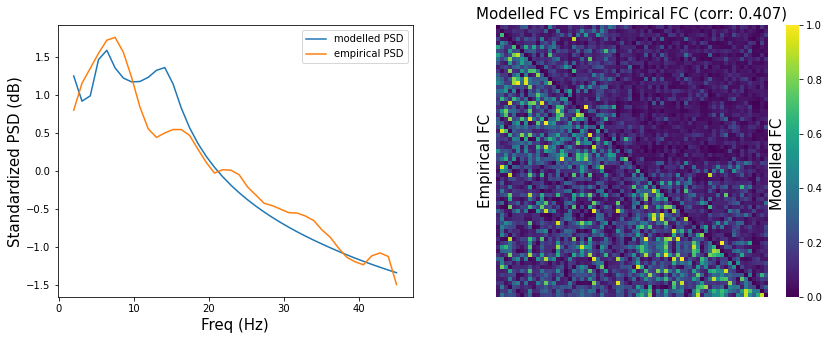

In [103]:
sbi_sgm.plot_compare("both")

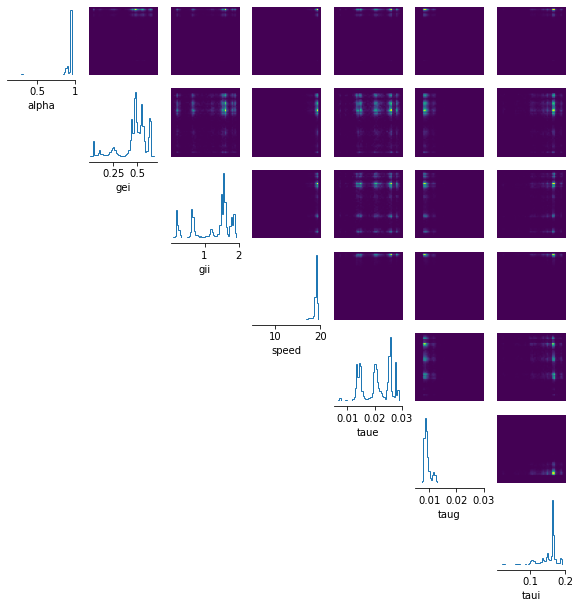

In [105]:
sbi_sgm.plot_pairdensity()

# Other fitting

## Fit with raw MEG

2024-02-27 17:08:33,720 - sbi_sgm_both - WARNING - Avoid placing too much trust in the estimated PSD, as it is derived through interpolation at various frequencies.


Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 29 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

{'alpha': 0.9518381719546228, 'gei': 0.3568494861497211, 'gii': 0.5372015011833446, 'speed': 12.326026549203322, 'taue': 0.010095324093615951, 'taug': 0.006206054906407187, 'taui': 0.16697704919026565}
The Pearson's corr is 0.407


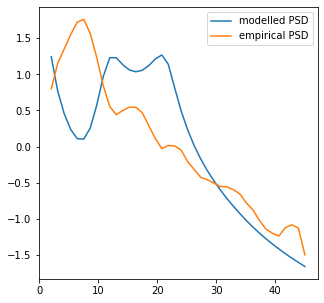

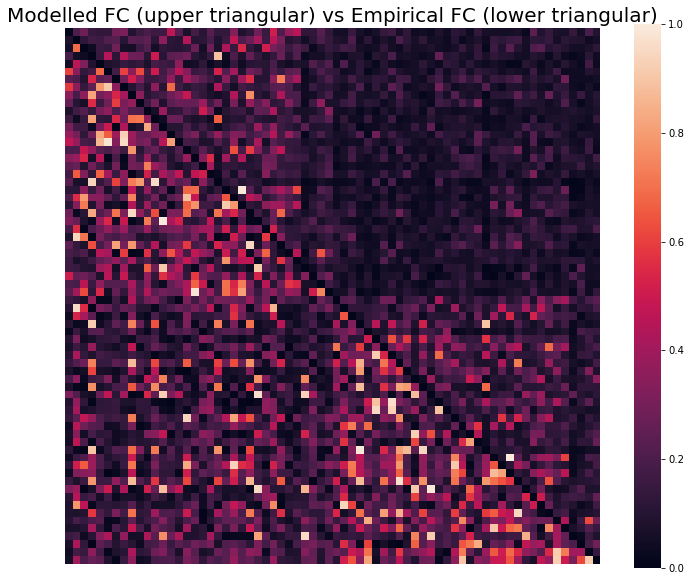

In [101]:
sbi_sgm = SBI_SGM(sgmmodel, 
                  save_folder=None, 
                  verbose=1, params={"fit_target":"both", 
                                    "num_prior_sps":500, 
                                    "num_round":3})
sbi_sgm.add_data(ts=meg, fs=600) # !!! 
sbi_sgm.SBI_fit(load=False)
sps = sbi_sgm.get_post_sps(10000);
sbi_sgm.get_point_est()
print(sbi_sgm.pt_est_name)
sbi_sgm.get_model_fc()
sbi_sgm.get_model_psd();

plt.figure(figsize=[5, 5])
plt.plot(FREQS, sbi_sgm.model_psd.mean(axis=0), label="modelled PSD")
plt.plot(FREQS, psd_2tr(psd).mean(axis=0), label="empirical PSD")
plt.legend()


# let us compare the fitted and the empirical ones
uidxs = np.triu_indices_from(fc, k=1)
lidxs = np.tril_indices_from(fc, k=1)
est_vec = sbi_sgm.model_fc[uidxs]
std_empfc, empvec = sbi_sgm.get_stdfc(fc);
corr = scipy.stats.pearsonr(estvec, empvec)[0];

mat = np.zeros_like(fc)
mat[lidxs] = std_empfc[lidxs]
mat[uidxs] = sbi_sgm.model_fc[uidxs]

plt.figure(figsize=[12, 10])
plt.title(f"Modelled FC (upper triangular) vs Empirical FC (lower triangular)", 
          fontsize=20)
sns.heatmap(mat, square=True)
plt.xticks([])
plt.yticks([]);
print(f"The Pearson's corr is {corr:.3f}");

In [ ]:
sbi_sgm = SBI_SGM(sgmmodel, 
                  save_folder=None, 
                  verbose=1, params={"fit_target":"fc", 
                                    "num_prior_sps":500, 
                                    "num_round":3})
sbi_sgm.add_data(fc=fc) # !!! 
sbi_sgm.SBI_fit(load=False)
sps = sbi_sgm.get_post_sps(10000);
sbi_sgm.get_point_est()
print(sbi_sgm.pt_est_name)
sbi_sgm.get_model_fc()
sbi_sgm.get_model_psd()


# let us compare the fitted and the empirical ones
_, estvec = sbi_sgm.get_stdfc(sbi_sgm.model_fc)
std_empfc, empvec = sbi_sgm.get_stdfc(fc);
corr = scipy.stats.pearsonr(estvec, empvec)[0];

mat = np.zeros_like(fc)
uidxs = np.triu_indices_from(fc, k=1)
lidxs = np.tril_indices_from(fc, k=1)
mat[lidxs] = std_empfc[lidxs]
mat[uidxs] = sbi_sgm.model_fc[uidxs]

plt.figure(figsize=[12, 10])
plt.title(f"Modelled FC (upper triangular) vs Empirical FC (lower triangular)", 
          fontsize=20)
sns.heatmap(mat, square=True)
plt.xticks([])
plt.yticks([]);
print(f"The Pearson's corr is {corr:.3f}");

2024-02-27 16:50:28,693 - sbi_sgm_both - WARNING - Avoid placing too much trust in the estimated PSD, as it is derived through interpolation at various frequencies.


Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Training neural network. Epochs trained: 2